# Data cleaning and link prediction between actors

## Necessary libraries

In [ ]:
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Data

### Create connection with datasets

#### Files via shareable link

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1T_cW32Wtp_D-5XAFo7SScy-gO0phlHhp/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.ratings.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1tyqWloBbdzxFROWRtrAZAsr82HwJQT7T/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.principals.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1yhwoApklCg0y_RM-gqwxy80l-rMQvCWH/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('name.basics.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1JCa4kYiKLbcsv8Ji-XH-qgoxQ9c9zgUi/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('movies.shown.US.csv')

### Read in datasets

In [ ]:
ratings = pd.read_csv("title.ratings.tsv", sep='\t')

In [ ]:
crew = pd.read_csv("title.principals.tsv", sep='\t')

In [ ]:
movies = pd.read_csv("movies.shown.US.csv")

In [ ]:
names = pd.read_csv("name.basics.tsv", sep='\t')

### Clean data

In [ ]:
print(len(ratings))
print(len(crew))
print(len(movies))
print(len(names))

1149651
44619193
220291
10916797


In [ ]:
# Limits for years to calculate
fromYear = 2019
toYear = 2020

In [ ]:
names = names[names.deathYear == '\\N'] # remove deceased crew from names data

In [ ]:
movies['startYear'] = movies['startYear'].replace({'\\N':'0'}) # replace the year to 0 if it isnt given
movies = movies.astype({"startYear":'int'}) # make the years into integers
movies = movies[(movies.startYear >= fromYear) & (movies.startYear <= toYear)] # filter out all years that are not in the given range
movies = movies[movies.tconst.isin(crew.tconst)] # remove movies that no longer have crew data
movies = movies[movies.tconst.isin(ratings.tconst)] # remove movies that don't have ratings

In [ ]:
crew = crew[crew.nconst.isin(names.nconst)] # remove deceased crew from crew data
ratings = ratings[ratings.tconst.isin(movies.tconst)] # remove ratings of non-movies
crew = crew[crew.tconst.isin(movies.tconst)] # remove crew of non-movies
names = names[names.nconst.isin(crew.nconst)] # remove names of people not in the new crew list

In [ ]:
print(len(ratings))
print(len(crew))
print(len(movies))
print(len(names)) 

8536
75241
8536
62189


In [ ]:
movies.to_csv('movie.basics.cleaned.csv')
ratings.to_csv('movie.ratings.cleaned.csv')
crew.to_csv('movie.principals.cleaned.csv')
names.to_csv('names.basics.cleaned.csv')

In [ ]:
actors = crew[(crew.category=="actor") | (crew.category=="actress")] # filter out only actors and actresses from the crew
print("Not all movies have data about actors:")
print("Number of movies:", len(movies))
print("Number of movies with actor data:", len(actors.tconst.unique()))
movies_filtered = movies[movies.tconst.isin(actors.tconst)] # Lets remove movies without actor data
names_filtered = names[names.nconst.isin(actors.nconst)] # remove names of people not in the actors list

Not all movies have data about actors:
Number of movies: 8536
Number of movies with actor data: 7136


In [ ]:
merged_data = pd.merge(names_filtered, actors, how="left", on="nconst")

In [ ]:
merged_data.to_csv('merged_data.cleaned.csv')

## Rateing

In [ ]:
merged_data

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,ordering,category,job,characters
0,nm0000047,Sophia Loren,1934,\N,"actress,soundtrack","tt0076085,tt0060121,tt0058335,tt0054749",tt10627584,1,actress,\N,"[""Madame Rosa""]"
1,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt10670442,1,actress,\N,"[""Lang Ping""]"
2,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt4566758,3,actress,\N,"[""Xianniang""]"
3,nm0000092,John Cleese,1939,\N,"actor,writer,producer","tt0085959,tt0063929,tt0095159,tt0071853",tt4426464,4,actor,\N,"[""Otto Von Walrus""]"
4,nm0000092,John Cleese,1939,\N,"actor,writer,producer","tt0085959,tt0063929,tt0095159,tt0071853",tt5277030,3,actor,\N,"[""Brian King""]"
...,...,...,...,...,...,...,...,...,...,...,...
29413,nm9991306,Stella Carlish,\N,\N,actress,"tt8997134,tt8342598",tt8997134,1,actress,\N,"[""Cassie""]"
29414,nm9992452,Yuki Katayama,\N,\N,actress,"tt6340500,tt8185442,tt8845988,tt7493810",tt8845988,4,actress,\N,\N
29415,nm9992659,Daniar Alshinov,\N,\N,actor,"tt13294010,tt11146190,tt11155928,tt13294064",tt10867768,1,actor,\N,"[""Bekzat""]"
29416,nm9993103,Brianna Roy,\N,\N,"actress,writer,camera_department","tt9001550,tt9486184,tt7846794,tt9212760",tt9486184,2,actress,\N,"[""Stacy""]"


In [ ]:
# Add ratings of movies to the table (movies 2011-2020)
koos2020 = pd.merge(merged_data, ratings, on='tconst')
# Sum total votes given to an actor
votesums2020 = koos2020.groupby('nconst')['numVotes'].sum()
votesums2020 = votesums2020.to_frame(name="sumVotes")
# Add that to original table
koos2020 = koos2020.join(votesums2020, on='nconst')
# Calculate the weight of any given rating
koos2020['weightedRating'] = (koos2020['averageRating']*(koos2020['numVotes']/koos2020['sumVotes'])).round(2)
# Sum together weighted ratings to get actor average rating
totRating2020 = koos2020.groupby('nconst')['weightedRating'].sum()
totRating2020 = totRating2020.to_frame(name="RatingTo2020")
# Add that to original table
koos = koos2020.join(totRating2020, on="nconst")

In [ ]:
koos

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,ordering,category,job,characters,averageRating,numVotes,sumVotes,weightedRating,RatingTo2020
0,nm0000047,Sophia Loren,1934,\N,"actress,soundtrack","tt0076085,tt0060121,tt0058335,tt0054749",tt10627584,1,actress,\N,"[""Madame Rosa""]",6.8,11799,11799,6.80,6.80
1,nm0139528,Renato Carpentieri,1943,\N,actor,"tt0106201,tt0100389,tt5765192,tt0105188",tt10627584,3,actor,\N,"[""Dr. Coen""]",6.8,11799,12867,6.24,6.71
2,nm12070255,Iosif Diego Pirvu,\N,\N,actor,\N,tt10627584,4,actor,\N,"[""Iosif""]",6.8,11799,11799,6.80,6.80
3,nm5098066,Ibrahima Gueye,\N,\N,"actor,stunts","tt10627584,tt2184316,tt9643038",tt10627584,2,actor,\N,"[""Momo""]",6.8,11799,11799,6.80,6.80
4,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt10670442,1,actress,\N,"[""Lang Ping""]",6.7,832,120861,0.05,5.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29413,nm9960714,Daniel Nicholson,\N,\N,actor,"tt12700334,tt8677030,tt8676944",tt12700334,3,actor,\N,"[""Obi Wan Kenobi"",""Nute Gunray""]",6.9,9,9,6.90,6.90
29414,nm9964007,Ahed Bhar,\N,\N,NaN,tt8667126,tt8667126,3,actor,\N,"[""Playing Himself""]",6.4,14,14,6.40,6.40
29415,nm9964008,Nassim Assaad,\N,\N,NaN,tt8667126,tt8667126,2,actor,\N,"[""Playing Himself""]",6.4,14,14,6.40,6.40
29416,nm9964009,Assad Chaftari,\N,\N,NaN,tt8667126,tt8667126,4,actor,\N,"[""Playing Himself""]",6.4,14,14,6.40,6.40


In [ ]:
df = pd.DataFrame()

df["Movie"] = koos.tconst.unique()

In [ ]:
for i in df.Movie:
  names = koos[koos["tconst"] == i]
  names = names.reset_index(drop=True)
  for j in range(len(names)):
    df.loc[df['Movie'] == str(i), f"f{j}"] = names["RatingTo2020"][j]
  df.loc[df['Movie'] == str(i), "Rating"] = float(ratings.loc[ratings["tconst"] == str(i), "averageRating"])
  df.loc[df['Movie'] == str(i), "Votes"] = int(ratings.loc[ratings["tconst"] == str(i), "numVotes"])

In [ ]:
df = df.fillna(0)

In [ ]:
x = df[["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9"]]
y = df["Rating"]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size = 0.3)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
lr = RandomForestRegressor()

lr.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = lr.predict(xtest)

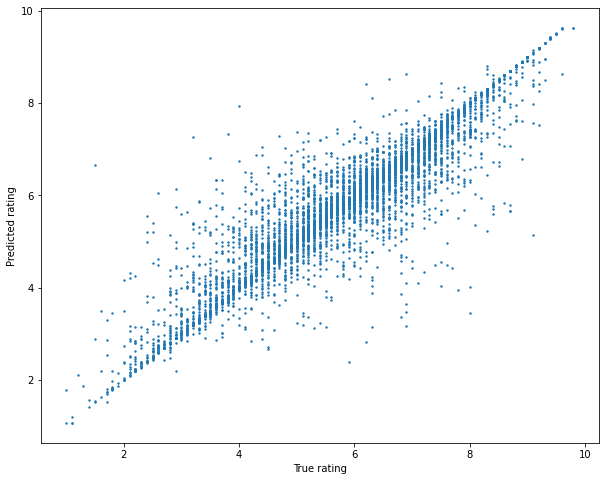

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(ytest, y_pred, s = 2)
plt.xlabel("True rating")
plt.ylabel("Predicted rating")
plt.show()

In [ ]:
df

,Movie,f0,f1,f2,f3,Rating,Votes,f4,f5,f6,f7,f8,f9
0,tt1667150,6.6,5.86,5.50,5.50,5.5,1207.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt3125472,6.6,7.20,6.78,7.20,7.2,5550.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt4591310,6.6,5.92,6.28,5.78,5.9,2889.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt1053810,6.5,6.38,6.68,6.85,6.2,42632.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt1449283,6.5,7.19,7.76,0.00,7.2,22452.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25983,tt8619974,5.5,5.50,5.50,5.50,5.5,22.0,5.5,5.5,5.5,5.5,0.0,0.0
25984,tt8634348,3.4,3.40,3.40,3.40,3.4,787.0,0.0,0.0,0.0,0.0,0.0,0.0
25985,tt8665364,7.4,7.40,7.40,7.40,7.4,14.0,0.0,0.0,0.0,0.0,0.0,0.0
25986,tt6594148,5.5,0.00,0.00,0.00,5.5,34.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evoluting

In [ ]:
y_pred_evo = lr.predict(x)

In [ ]:
y_pred_evo

array([6.781, 6.385, 5.644, ..., 6.9  , 6.9  , 6.4  ])

In [ ]:
y

0       6.8
1       6.7
2       5.6
3       4.7
4       5.3
       ... 
7131    5.9
7132    5.2
7133    6.9
7134    6.9
7135    6.4
Name: Rating, Length: 7136, dtype: float64

In [ ]:
coef = np.polyfit(y, y_pred_evo, 1)
coef

array([0.9414463 , 0.33369288])

In [ ]:
p = np.poly1d(coef)
p

poly1d([0.9414463 , 0.33369288])

In [ ]:
summation = 0  #variable to store the summation of differences
n = len(y) #finding total number of items in list
for i in range (0,n):  #looping through each element of the list
  difference = y[i] - y_pred_evo[i]  #finding the difference between observed and predicted value
  squared_difference = difference**2  #taking square of the differene 
  summation = summation + squared_difference  #taking a sum of all the differences
MSE = summation/n  #dividing summation by total values to obtain average
print ("The Mean Square Error is: " , MSE)

The Mean Square Error is:  0.14832425697480353


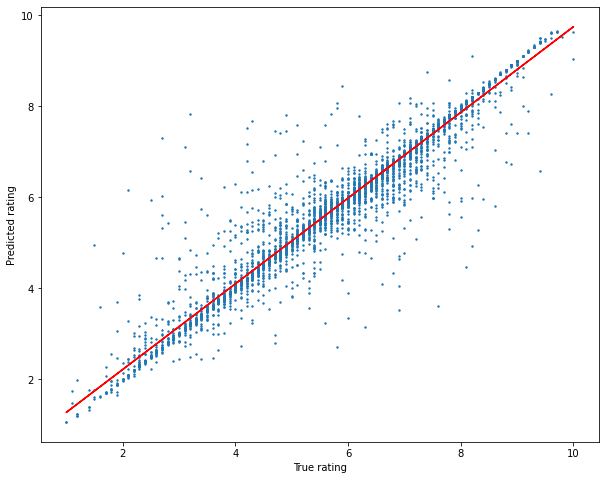

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(y, y_pred_evo, s = 2)
plt.plot(y, p(y), '-', color = "red")
plt.xlabel("True rating")
plt.ylabel("Predicted rating")
plt.show()